___
# Regression
---

<center><img src="https://python.gel.ulaval.ca/media/sio-u009/mlprocess_3.png" alt="Processus d'apprentissage automatique" width="50%"/></center>

# Exemple 1 : Prédiction de la durée du retard d'un vol selon les conditions

Dans cet exemple nous allons utiliser plusieurs ensembles de données publics pour apprivoiser les différentes manières de prédire une valeur continue. 

Nous allons utiliser la librairie `statsmodels`, qui utilise une formulation des problèmes de regression proche du langage R. 

## Les données : Agrégation de plusieurs sources de données pour la prédiction de vols aériens

Mais avant d'arriver aux données, initialisons notre environnement, importons des librairies nécessaires et téléchargeons les données.

In [ ]:
# Importation des fichiers de données
import wget

!rm './airports.csv' './flights.csv' './planes.csv' './weather.csv' './airlines.csv'

wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/airports.csv','./airports.csv')
wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/flights.csv','./flights.csv')
wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/planes.csv','./planes.csv')
wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/weather.csv','./weather.csv')
wget.download('https://raw.githubusercontent.com/iid-ulaval/EEAA-datasets/master/airlines.csv','./airlines.csv')

In [ ]:
# Basé sur les exercices en R de Thierry Duchesne, Sophie Baillargeon et Marie-Pier Côté 
import pandas as pd
import math
from plotnine import *
import numpy as np
import statsmodels.api as sm
import statsmodels.tools as smt
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


## Présentation des données

Nous allons analyser des données concernant des vols d’avions. Nous allons tenter de cerner quelles variables ont une influence sur les retards dans les arrivées des vols.

Les données sont distribuées dans le package R `nycflights13` et sont fournies ici dans des fichiers csv. Le fichier `flights.csv` contient des informations sur tous les vols intérieurs qui sont partis d’un aéroport de la région de New York en 2013. Les trois aéroports de la région de New York sont John F Kennedy Intl (`JFK`), Newark Liberty Intl (`EWR`) et La Guardia (`LGA`).

In [ ]:
airports = pd.read_csv("airports.csv")
flights = pd.read_csv("flights.csv", parse_dates=['time_hour'], index_col=0)
planes = pd.read_csv("planes.csv")
weather = pd.read_csv("weather.csv", parse_dates=['time_hour'])
airlines = pd.read_csv("airlines.csv", index_col=0)

airports[airports.faa.isin(flights.origin)]

Intéressons-nous aux vols en direction de l’aéroport General Edward Lawrence Logan Intl (`BOS`) de Boston pendant le mois de juillet.


<center>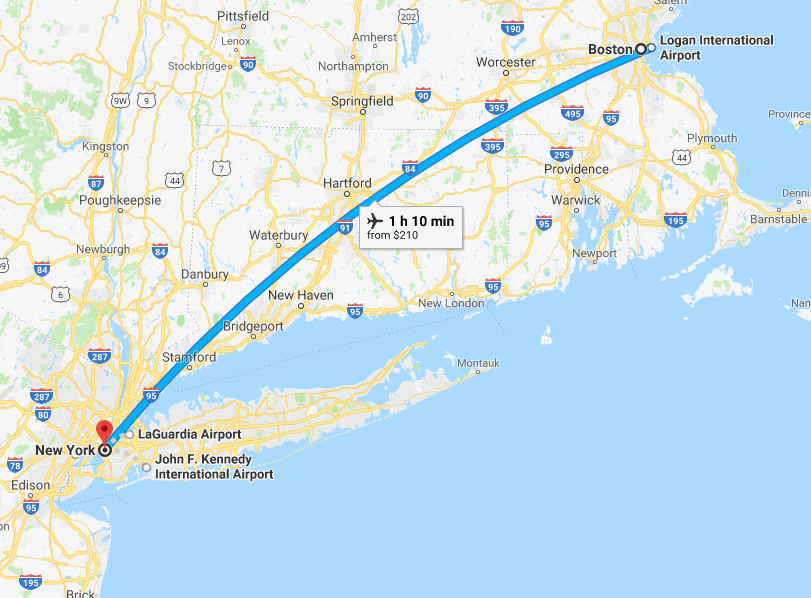</center>

# Variables mesurées

Description des variables selon la documentation officielle du package `nycflights13`. 

Variable réponse Y :

* `arr_delay` : Arrival delays, in minutes. Negative times represent early departures/arrivals

Variables explicatives potentielles (présélection) :

* `dep_delay` : Departure delays, in minutes. Negative times represent early departures/arrivals
* `carrier` : Two letter carrier abbreviation. See `airlines` to get name
* `origin` : Origin. See `airports` for additional metadata
* `time_hour` : Scheduled date and hour of the flight -> Nous allons en tirer les variables `week_day`, puis `wknd`.
* `hour` : Hour of scheduled departure
* `seats` : Number of seats
* `dewp` : Dewpoint in F
* `humid` : Relative humidity
* `wind_dir` : Wind direction (in degrees) -> Nous allons en tirer les variables `wind_sin` et `wind_cos`.
* `wind_speed` : speed (in mph) -> Nous allons en tirer les variables `wind_sin` et `wind_cos`.
* `precip` : Preciptation, in inches -> Nous allons en tirer l’indicatrice `precip_indic`.
* `pressure` : Sea level pressure in millibars
* `visib` : Visibility in miles

# Préparation du jeu de données

Nous allons d’abord créer un jeu de données contenant uniquement les vols qui nous intéressent (destination = BOS et mois = 7). Puis, ajoutons à ce jeu de données de nouvelles variables :

* nombre de sièges dans l’avion, tiré du du jeu de données `planes.csv`;
* variables concernant la météo au moment du départ du vol, à l’aéroport d’origine, tirées du jeu de données `weather.csv`;
* quelques nouvelles variables obtenues par transformation d’autres variables (expliquées plus loin).


In [ ]:
# Vols en direction de Boston en juillet
BOS = flights[(flights.dest=='BOS') & (flights.month==7)]
BOS.head()

In [ ]:
# Ajout du nombre de sièges dans l'avion
BOS_seats=BOS.join(planes.set_index('tailnum').filter(items=['tailnum', 'seats']), on='tailnum')
BOS_seats.head()

In [ ]:
# Ajout de variables météo
weather_filtered = weather.filter(items=['origin', 'time_hour', 'dewp', 'humid', 'wind_dir', 'wind_speed', 'precip', 'pressure', 'visib'])
BOS_seats.set_index(['origin', 'time_hour'])
BOS_weather = BOS_seats.join(weather_filtered.set_index(['origin', 'time_hour']), on=['origin', 'time_hour'])
BOS_weather.head()

In [ ]:
# Ajout de nouvelles variables créées par transformation d'autres variables :
# - jour de la semaine du départ du vol
BOS_addedvars = BOS_weather.copy()
BOS_addedvars['week_day'] = BOS_addedvars.apply(lambda row: row.time_hour.strftime('%A'), axis=1)

# - indicatrice de la fin de semaine (TRUE pour un vol de fin de semaine, FALSE sinon)
BOS_addedvars['wknd'] = (BOS_addedvars['week_day']=='Saturday') | (BOS_addedvars['week_day']=='Sunday')

# - indicatrice de l'heure de pointe de fin de journée 
#   (True si le vol a décolé entre 17 et 19 heures du soir, False sinon)
BOS_addedvars['evening_rush_hour'] = BOS_addedvars['hour'].isin([17, 18])

# - variables pour représenter correctement modéliser les vents
BOS_addedvars['wind_sin'] = BOS_addedvars.apply(lambda row: row.wind_speed*math.sin(row.wind_dir*math.pi/180), axis=1)
BOS_addedvars['wind_cos'] = BOS_addedvars.apply(lambda row: row.wind_speed*math.cos(row.wind_dir*math.pi/180), axis=1)

# - indicatrice de la présence de précipitation (True s'il y a des précipitations, False sinon)
BOS_addedvars['precip_indic'] = (BOS_addedvars['precip'] > 0)

# On ne conserve que les lignes avec aucune donnée manquante, pour les besoins de notre exemple.
BOS_addedvars = BOS_addedvars.dropna()
BOS_addedvars

### Données test
Avant de commencer, mettons tout de suite de côté un sous-ensemble des données pour tester la qualité des prévisions obtenues de nos modèles. Nous formons donc une base de données test. Ce sous-ensemble est obtenu en sélectionnant de façon complètement aléatoire 20% des vols dans les données. Nous ne formons pas de base de données de validation. Si nous avons besoin de données de validation, par exemple pour déterminer des valeurs d’hyperparamètres, nous procéderons par validation croisée.

In [ ]:
# Sélection aléatoire de 20% des observations
seed = 75 # pour avoir des résultats réplicables

BOS_copy = BOS_addedvars.copy()
# Données test
BOS_test_set = BOS_copy.sample(frac=0.2, random_state=seed)
# Données d'entrainement
BOS_train_set = BOS_copy.drop(BOS_test_set.index)

Ainsi, les 1029 vols au total sont divisés en 823 vols pour l’entraînement des modèles, 206 vols pour tester la performance prédictive des modèles.

## Objectifs

Les objectifs de l’analyse de données sont les suivants :

* identifier les facteurs (variables) influençant les retards à l’arrivée, pour mieux comprendre les causes potentielles des retards ;
* développer un modèle capable de prédire les temps de retard à l’arrivée juste après le décollage du vol (temps de retard du départ connu).

Nous mesurerons la qualité de la prédiction de la variable numérique `arr_delay` avec la racine carrée de l’erreur quadratique moyenne de prédiction.

**Exercice.** Exécutez toutes les lignes de code ci-haut en vérifiant qu'aucun message d'erreur n'est obtenu. Utilisez la méthode `shape` pour voir les dimensions des bases de données `BOS_train_set` et `BOS_test_set`.

# Analyse préliminaire des données

Avant de commencer l’analyse, il est important de se familiariser avec le contenu de la base de données d’entrainement, `BOS_train_set`.

**Exercice.** Utilisez la fonction `describe()` pour obtenir les statistiques descriptives de chaque variable de `BOS_train_set`. Remarquez les différents types de variables: continues, booléen, catégorielles.

Évidemment, `arr_delay` est fortement relié à `dep_delay`, comme on peut le voir dans le graphique en nuage de points ci-dessous. Ce type de graphique est approprié lorsque la variable exogène est aussi continue.

In [ ]:
ggplot(BOS_train_set, aes(x='dep_delay ', y='arr_delay')) \
+ geom_point() \
+ geom_abline( aes(intercept=0, slope=1)) \
+ labs(title="Relation entre les temps de retard à l'arrivée et au départ")

Nous souhaitons comprendre quelles autres variables influencent `arr_delay`. Pour explorer cette question, produisons quelques graphiques représentant la relation entre l’écart `arr_delay - dep_delay` et certaines variables explicatives disponibles. Cette différence entre le temps de retard à l’arrivée et celui au départ est l’écart entre la durée prévue du vol et sa durée réelle (déviation de durée).

Comme on peut le voir dans le diagramme à moustache ci-dessous, certaines compagnies aériennes semblent avoir plus souvent des arrivées en retard que d’autres. Ce type de graphique est approprié lorsque la variable exogène est catégorielle.

In [ ]:
ggplot(BOS_train_set) \
+ geom_boxplot(aes(x='carrier', y='arr_delay - dep_delay')) \
+ geom_abline( aes(intercept=0, slope=0), linetype='dashed') \
+ labs(title="Relation entre la déviation de durée et le transporteur")

In [ ]:
airlines[airlines.carrier.isin(BOS_train_set.carrier)]

Cependant, inclure cette variable dans un modèle statistique est difficile, car certains transporteurs sont très peu présents dans la base de données. Par exemple, il y a seulement 2 vols du transporteur American Airlines Inc. (`AA`).

In [ ]:
pd.crosstab(index=BOS_train_set.carrier, columns=BOS_train_set.origin, margins=True, margins_name='Sum')

La table de fréquences croisées précédente nous montre que, mis à part JetBlue Airways (`B6`) qui dessert deux aéroports de New York, tous les autres transporteurs ne desservent qu’un seul aéroport. Pour travailler avec une variable catégorique dont chacune des modalités comporte suffisamment d’observations pour bien estimer les paramètres du modèle, nous allons seulement considérer la variable `origin`, soit l’aéroport d’où le vol est parti. Cette variable confond l’effet de l’aéroport lui-même, ainsi que celui de la compagnie aérienne.

**Exercice.** Utilisez la fonction `geom_boxplot()` pour tracer le diagramme à moustache de `arr_delay - dep_delay` en fonction de la variable origin.

Les villes de New York et Boston étant très rapprochées, on peut penser que les vols d’avion entre les deux villes sont principalement des vols d’affaire. Il y a plus de vols la semaine que le fin de semaine et, selon le graphique suivant, les vols de semaine ont tendance à avoir plus de retard que ceux de fin de semaine.

**Exercice.** Combien y a-t-il de vols la semaine et la fin de semaine? Utilisez la fonction `value_counts()` et la variable indicatrice `wknd`. Tracez le diagramme à moustache de `arr_delay - dep_delay` en fonction de wknd.

Le moment de la journée auquel part un vol a peut-être une influence sur son retard potentiel. Nous pensons que les vols partant pendant l’heure de pointe de fin de journée (`hour` = 17 ou 18) présentent peut-être des durées plus longues que prévues. Cela est plausible vu le diagramme à moustache suivant.

In [ ]:
# Diagramme à moustache de `arr_delay - dep_delay`
# en fonction de l'indicatrice `evening_rush_hour`
ggplot(BOS_train_set) \
+ geom_boxplot(aes(x='evening_rush_hour', y='arr_delay - dep_delay')) \
+ geom_abline( aes(intercept=0, slope=0), linetype='dashed') \
+ labs(title="Relation entre la déviation de durée et l'heure du pointe")

Le nombre de sièges dans un avion représente sa taille. La variable `seats` pourrait être vue à la fois comme une une variable numérique, ou comme une variable catégorique ordinale. Étant donné que les avions qui ont effectué les vols analysés sont parfois les mêmes, ou du même modèle, les valeurs de nombre de sièges peuvent uniquement prendre un petit nombre de valeurs possibles. Nous traiterons cette variable comme une variable numérique.

**Exercice.** Est-ce que la taille d’un avion a une influence sur les retard des vols à l’arrivée? Tracez un nuage de points de `arr_delay - dep_delay` en fonction de `seats`.

Les vents peuvent certainement soit ralentir ou accélérer un avion en vol, en fonction de leur direction relativement à la direction dans laquelle l’avion se déplace et en fonction de leur force. Les variables relatives aux vents incluses dans les données météo (jeu de données `weather`) sont la direction du vent (`wind_dir`) et sa vitesse (`wind_speed`).

La variable `wind_dir` est particulière. En effet, une direction de vent de disons 1 degrés est pratiquement la même chose qu’une direction de 359 degrés. On qualifie ce type de variable de circulaire. Nous allons faire comme les auteurs de l’article https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4048198/ et utiliser les variables suivantes pour représenter le vent :

* `wind_sin` = `wind_speed` * sin(`win_dir` en radians) :
* valeur positive = vent provenant de l’est
* `wind_cos` = `wind_speed` * cos(`win_dir` en radians) :
* valeur positive = vent provenant du nord

Voici les nuages de points de `arr_delay - dep_delay` en fonction de `wind_sin` et `wind_cos`.

In [ ]:
ggplot(BOS_train_set, aes(x='wind_sin', y='arr_delay - dep_delay')) \
+ geom_point()\
+ labs(title="Relation entre la déviation de durée et la vitesse des vents")

In [ ]:
ggplot(BOS_train_set, aes(x='wind_cos', y='arr_delay - dep_delay')) \
+ geom_point()\
+ labs(title="Relation entre la déviation de durée et la direction des vents")

**Exercice.** Utilisez le graphique approprié pour visualiser la relation entre `arr_delay - dep_delay` et la variable qui indique s'il y a des précipitations, `precip_indic`.

---
# Régression linéaire simple
---

D’abord, évaluons la force de la relation entre `arr_delay` et `dep_delay`.

**Exercice.** Utilisez la fonction de `statsmodels`, `ols().fit()` avec les données `BOS_train_set` pour ajuster le modèle de régression linéaire simple. Stockez votre modèle dans un objet nommé `modele_simple`. 

**Exercice.** Quelles sont les estimations des paramètres β<sub>0</sub> et β<sub>1</sub> ? Interprétez ces deux valeurs dans le contexte des vols d’avion.

Tel qu’attendu lors de l’analyse préliminaire, les variables sont très fortement reliées. Le graphique en nuage de points avec la droite de régression ajustée peut être obtenu de façon simple comme suit:

In [ ]:
ggplot(BOS_train_set, aes(x='dep_delay ', y='arr_delay')) + geom_point() \
+ geom_abline( aes(intercept=modele_simple.params['Intercept'], slope=modele_simple.params['dep_delay']), color='red')  

**Exercice.** Quel est le pourcentage de la variabilité dans le délai à l'arrivée qui est expliqué par le délai au décollage ?

Si ce modèle simple était utilisé pour prédire `arr_delay`, nous pourrions nous attendre à une erreur quadratique moyenne de prédiction valant :

In [ ]:
X_test = pd.DataFrame(BOS_test_set.dep_delay)

mse_simple = smt.eval_measures.rmse(BOS_test_set['arr_delay'], modele_simple.predict(X_test))**2
mse_simple

---
# Régression linéaire multiple
---

Voyons si nous pouvons améliorer le modèle en incluant plus de variables. Dans un premier temps, mettons dans le modèle toutes les variables potentielles que nous avons présélectionnées.

In [ ]:
modele_complet = smf.ols('arr_delay ~ dep_delay + origin + wknd + evening_rush_hour + seats + dewp + humid + wind_sin + wind_cos + precip_indic + pressure + visib', BOS_train_set).fit()
modele_complet.summary()

**Exercice** Quel pourcentage de la variabilité observée dans `arr_delay` est expliquée par le modèle?

Nous retrouvons des effets vus dans les graphiques exploratoires.

Par exemple, le coefficient pour la variable `evening_rush_hour` est positif et fortement significatif. Ainsi, un départ pendant l’heure de pointe de fin de journée est associé à des des délais de retard plus grands.

**Exercice**. Faire un test T (fonction `t_test()` sur `modele_complet`) sur le paramètre lié à la variable `evening_rush_hour`.  Utilisez au seuil de signification de 1%. 

**Exercice.** Interpréter les coefficients estimés pour les variables `seats` et `wknd` dans le contexte du problème.

La variable `origin` étant catégorique à 3 modalités, elle est représentée par deux indicatrices dans le modèle. Comme nous pouvions nous y attendre, l’indicatrice des départs de l’aéroport `LGA` a un coefficient positif et significatif, ce qui indique que les vols partant de cet aéroport ont tendance à avoir plus de retard que ceux partant de `NWK`. N’oublions pas que ces conclusions s’appliquent seulement pour les vols vers Boston en juillet. Tous les vols partant de l’aéroport `LGA` vers l’aéroport `BOS` sont offerts par US Airways Inc. Alors il est impossible de savoir si l’effet dû à l’aéroport ou s’il est dû à la compagnie aérienne.

Pour tester si la variable `origin` a un impact globalement, il faut faire un test simultanément sur ses deux paramètres. Voici une façon de réaliser ce test.

In [ ]:
anova_table = sm.stats.anova_lm(modele_complet, typ=3)
anova_table

Pour les variables numériques ou catégorique à 2 modalités, les tests rapportés dans ce tableau sont équivalents aux tests précédents dans le sommaire du modèle (même seuils observés). Pour la variable `origin`, il s’agit d’un test global. Le très petit seuil observé nous indique que l’effet de la variable `origin` est significatif.

Pour le premier vol de la base de données test

In [ ]:
un_exemple_test = BOS_test_set.head(1)
un_exemple_test

Quel délai à l’arrivée serait raisonnable selon le modèle?

**Exercice.** Donner un intervalle de confiance au niveau 95% pour le délai moyen à l'arrivée dans ces conditions. Donner également un intervalle de confiance pour le délai à l'arrivée d'un vol en particulier avec ces conditions. Est-ce que la vraie valeur observée se trouve dans ce dernier intervalle de confiance?

**Exercice.** Tracer un nuage de points des prévisions en fonction des observations dans l'échantillon test. Est-ce que le modèle semble bon?

Maintenant, mesurons la qualité de la prédiction de ce modèle pour des nouveaux vols de New York vers Boston en juillet.

In [ ]:
# Erreur quadratique moyenne de prédiction
mse_complet = smt.eval_measures.rmse(BOS_test_set['arr_delay'], modele_complet.predict(BOS_test_set))**2
mse_complet

Cet indice a diminué comparativement au modèle de régression simple (209.48 versus 256.79).

## Sélection de variables 

Voyons si effectuer une sélection de variables améliore davantage les prévisions.

### Sélection de variables par sélection de sous-modèles

Ajustez les modèles suivants en utilisant les variables suivantes :
* A: origin wknd evening_rush_hour precip_indic dep_delay seats humid wind_sin wind_cos pressure 
* B: origin wknd evening_rush_hour precip_indic dep_delay seats wind_sin wind_cos pressure 
* C: origin wknd evening_rush_hour precip_indic dep_delay seats wind_sin pressure 
* D: origin evening_rush_hour dep_delay seats pressure 

Quel est le meilleur modèle selon l’AIC? Selon le R^2 ajusté? 


In [ ]:
modeles = {}
modeles['A'] = smf.ols('arr_delay ~ origin + wknd + evening_rush_hour + precip_indic + dep_delay + seats + humid + wind_sin + wind_cos + pressure', BOS_train_set).fit()
modeles['B'] = smf.ols('arr_delay ~ origin + wknd + evening_rush_hour + precip_indic + dep_delay + seats + wind_sin + wind_cos + pressure', BOS_train_set).fit()
modeles['C'] = smf.ols('arr_delay ~ origin + wknd + evening_rush_hour + precip_indic + dep_delay + seats + wind_sin + pressure', BOS_train_set).fit()
modeles['D'] = smf.ols('arr_delay ~ origin + evening_rush_hour + dep_delay + seats + pressure ', BOS_train_set).fit()

for m in range(ord('A'), ord('D')+1):
    print('Modele '+chr(m)+' (AIC, R² ajust.) : ' + str(modeles[chr(m)].aic) + ', ' + str(modeles[chr(m)].rsquared_adj))

Le meilleur modèle est donc le modèle C, à la fois pour le critère AIC et pour le R² ajusté. Nommez le `modele_select`.

In [ ]:
modele_select = modeles['C']
modele_select.summary()

**Exercice.** Est-ce que ce modèle est meilleur que les précédents pour prédire les délais d’arrivée de nouveaux vols entre New York et Boston en juillet? Utilisez la fonction `eval_measures.rmse` pour comparer les observations dans l’échantillon test et les prévisions obtenues avec la fonction predict et le modèle choisi.

## Lasso

Ajustons un modèle de régression lasso sur nos données d’entraînement, en considérant les mêmes variables que celles dans le modèle complet. 

Pour cela, nous allons utiliser la bibliothèque SciKit-Learn et les fonction de `Lasso()`. Notez que le `lambda` de la théorie est nommé `alpha` dans SciKit-Learn.

In [ ]:
X = BOS_train_set.copy()
X = X[X.columns[X.columns.isin(['dep_delay', 'origin', 'wknd', 'evening_rush_hour', 'seats', 'dewp', 'humid', 
                                'wind_sin', 'wind_cos', 'precip_indic', 'pressure', 'visib'])]]
X['origin'] = X['origin'].astype('category').cat.codes.astype('float64')

Y = BOS_train_set['arr_delay']

lasso_alphas = np.logspace(-2, 4, 200, base=10)

lasso = Lasso(normalize=True)
lasso_df = pd.DataFrame(columns=['log_alpha','coef_id', 'coef'])
lasso_coefs = []
lasso_mse = []
for alpha in lasso_alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X, Y)
    for idc, c in enumerate(lasso.coef_):
        lasso_df = lasso_df.append({'log_alpha': np.log10(alpha), 
                                    'coef_id': idc,
                                    'coef': c }, ignore_index=True)
    lasso_coefs.append(lasso.coef_)

ggplot(lasso_df, aes(x='log_alpha', y='coef', group='coef_id', color='coef_id')) + geom_line()


In [ ]:
lcv = LassoCV(cv=10, random_state=413, normalize=True) # Search the min MSE by CV
lassocv_df = pd.DataFrame(columns=['log_alpha','mse_mean', 'mse_std'])
lcv.fit(X, Y)
mse_mean = lcv.mse_path_.mean(axis=1)
mse_std = lcv.mse_path_.std(axis=1)
for i, a in enumerate(lcv.alphas_):
    lassocv_df = lassocv_df.append({'log_alpha': np.log10(a), 
                                    'mse_mean': mse_mean[i],
                                    'mse_std': mse_std[i]}, ignore_index=True)
best_log_lamb = np.log10(lcv.alpha_)
    
ggplot(lassocv_df, aes(x='log_alpha', y='mse_mean')) \
+ geom_point(color='red') \
+ geom_errorbar(aes(ymin='mse_mean-mse_std', ymax='mse_mean+mse_std'), width=.1,  alpha=0.2) \
+ geom_vline( aes(xintercept=best_log_lamb), linetype='dotted') 

La valeur de l'hyperparamètre est donc

In [ ]:
best_lamb = lcv.alpha_
np.log10(best_lamb)

Les coefficients estimés par la régression Lasso pour cette valeur de λ sont

In [ ]:
coef_df = pd.DataFrame(columns = ['Caracteristique', 'Coeficient'])
coef_df['Caracteristique'] = X.columns
coef_df['Coeficient'] = lcv.coef_
coef_df = coef_df.append({'Caracteristique': 'Intercept', 'Coeficient': lcv.intercept_}, ignore_index=True)
coef_df

Dans cet exemple, la régression lasso propose de conserver seulement 9 variables explicatives. L’erreur quadratique moyenne diminue légèrement :

In [ ]:
 modele_lasso = smf.ols('arr_delay ~ dep_delay + origin + seats + pressure + visib + wknd + evening_rush_hour + wind_sin + precip_indic', BOS_train_set).fit()
modele_lasso.summary()

In [ ]:
# Erreur quadratique moyenne de prédiction
mse_lasso = smt.eval_measures.rmse(BOS_test_set.arr_delay, modele_lasso.predict(BOS_test_set))**2
mse_lasso

## Résumé des résultats pour la modélisation de arr_delay

On présente ci-dessous le résumé des résultats pour la modélisation du délai à l’arrivée. Le meilleur modèle selon le critère AIC est le modèle avec sélection de variable. Le meilleur modèle, selon le critère $R^2_a$, est le modèle avec sélection LASSO. Par contre, selon le critère de la puissance de prévision, le meilleur modèle est le modèle complet.

In [ ]:
arr = np.array([[modele_simple.aic, modele_simple.rsquared_adj, np.sqrt(mse_simple)],
                [modele_complet.aic, modele_complet.rsquared_adj, np.sqrt(mse_complet)],
                [modele_select.aic, modele_select.rsquared_adj, np.sqrt(mse_select)],
                [modele_lasso.aic, modele_lasso.rsquared_adj, np.sqrt(mse_lasso)]])
resume_mod_arr_delay = pd.DataFrame(arr, 
                                    columns=['AIC', 'R2ajust', 'RMSETest'], 
                                    index = ['modele simple', 'modele complet', 'modele avec sélection de variable', 'modele avec sélection LASSO'])

resume_mod_arr_delay

---
# Modèle linéaire généralisé - régression logistique
---

On crée une variable qui indique s’il y a un retard de 30 minutes ou plus à l’arrivée. La variable indicatrice arr_delay_30 vaut 1 si le vol a eu un retard d’au moins 30 minutes à l’arrivée, 0 sinon.

In [ ]:
BOS_train_set_logit = BOS_train_set.copy()
BOS_test_set_logit = BOS_test_set.copy()

# indicatrice du délai d'arrivé supérieur ou égal à 30 min.
BOS_train_set_logit['arr_delay_30'] = np.where(BOS_train_set_logit['arr_delay']>=30, 1, 0)
BOS_test_set_logit['arr_delay_30'] = np.where(BOS_test_set_logit['arr_delay']>=30, 1, 0)

Le tableau de fréquence de la variable réponse binaire est donné ci-dessous.

In [ ]:
print(BOS_train_set_logit.arr_delay_30.value_counts())

Nous mesurerons la qualité de la prédiction de la variable binaire `arr_delay_30` avec le taux d’erreur de classification. Voici une fonction pour calculer cet indice.

In [ ]:
def erreur(obs, pred):
    return np.mean(obs != pred)

## Régression logistique simple

Tout d’abord, ajustons le modèle de régression logistique simple, contenant uniquement la variable explicative dep_delay.

In [ ]:
modele_logit_simple_formule = 'arr_delay_30 ~ dep_delay'
modele_logit_simple = smf.logit(modele_logit_simple_formule, data=BOS_train_set_logit).fit()
print(modele_logit_simple.summary())
print('AIC :' + str(modele_logit_simple.aic))

Ce modèle possède un AIC de 267.27, que nous pourrons comparer avec les modèles suivants.

Une valeur prédite par ce modèle est une probabilité pour un vol d'être en retard de 30 minutes ou plus à l’arrivée. Si nous voulons utiliser ce modèle pour prédire si un vol sera ou non en retard de 30 minutes ou plus, il faut déterminer une règle pour fournir une prédiction binaire à partir de la probabilité prédite.

Le plus simple serait certainement de ramener à 0 (pas de retard de 30 minutes ou plus) les probabilités inférieures à 0.5 et à 1 (un retard de 30 minutes ou plus) les probabilités supérieures ou égales à 0.5. Cependant, un point de coupure à 0.5 n’est pas nécessairement le meilleur choix. Voyons ce point de coupure comme un hyperparamètre du modèle et utilisons une validation croisée pour trouver la meilleure valeur pour cet hyperparamètre.

Voici un programme Python qui effectue la validation croisée et sélectionne un point de coupure.

In [ ]:
BOS_train_set_logit_new_index = BOS_train_set_logit.reset_index()

nPlis = 10
# Séparation des données d'entraînement en 10 plis
nObsParPli = len(BOS_train_set_logit_new_index.index) // nPlis
nPlisPlus1 = len(BOS_train_set_logit_new_index.index) % nPlis
arr1 = np.arange(1,nPlisPlus1+1)
arr2 = np.arange(nPlisPlus1+1, nPlis+1)
indexes = np.concatenate((np.repeat(arr1, nObsParPli + 1), np.repeat(arr2, nObsParPli)))
np.random.seed(10)
indexes_permut = indexes.copy()
np.random.shuffle(indexes_permut) # permutation aléatoire
# Points de coupure évalués
coupures = np.linspace(0,1,101)
# Recherche en grille
grilleTaux = np.zeros((nPlis, 101))
for i in range(nPlis):
  # Ajustement du modèle sur les données pas dans le pli
  mi = smf.logit(modele_logit_simple_formule, data=BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] != i+1]).fit()
  # Prédiction pour les données dans le plis, avec différents points de coupure
  for j, c in enumerate(coupures):
    pred = (mi.predict(BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1]) >= c)
    grilleTaux[i][j] = erreur(obs = BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1].arr_delay_30, pred = pred)

# identification du meilleur point de coupure
tauxMoy = np.mean(grilleTaux, axis=0)
coupure_choisie = coupures[np.argmin(tauxMoy)]
coupure_choisie

Finalement, le point de coupure optimal selon la validation croisée est `0.55` pour cet exemple. Nous pouvons visualiser graphiquement ces résultats.

In [ ]:
coupure_df = pd.DataFrame(columns=['coupure','tauxMoy'])
coupure_df.coupure = coupures
coupure_df.tauxMoy = tauxMoy

ggplot(coupure_df, aes(x='coupure', y='tauxMoy')) \
+ geom_line() \
+ geom_vline( aes(xintercept=coupure_choisie), linetype='dotted') 

Taux d’erreur de classification sur les données test avec ce point de coupure :

In [ ]:
pred = (modele_logit_simple.predict(BOS_test_set_logit) >= coupure_choisie)
erreur_logit_simple = erreur(obs = BOS_test_set_logit.arr_delay_30, pred = pred)
erreur_logit_simple

## Régression logistique multiple

Incluons maintenant au modèle toutes les variables potentielles que nous avons présélectionnées.



In [ ]:
modele_logit_complet_chaine = 'arr_delay_30 ~ dep_delay + origin + wknd + evening_rush_hour + seats + dewp + humid + wind_sin + wind_cos + precip_indic + pressure + visib'
modele_logit_complet = smf.logit(modele_logit_complet_chaine, data=BOS_train_set_logit).fit()
print(modele_logit_complet.summary())
print('AIC :' + str(modele_logit_complet.aic))

Premièrement, remarquons que le AIC du modèle a diminué. Il vaut maintenant 260.82 (comparativement à 267.27 pour le modèle simple).

Mis à part `dep_delay`, la variable dont l’effet est le plus significatif est `pressure`, soit la pression au niveau de la mer. Le coefficient étant négatif, plus la pression est élevée, moins la probabilité pour un vol d’être en retard de 30 minutes ou plus est élevée. Les variables `evening_rush_hour` et `precip_indic` ont aussi un effet presque significatif. Leur coefficients sont positif, ce qui mène à l’interprétation qu’un vol décollant pendant l’heure de pointe du soir ou lorsqu’il pleut a une plus forte probabilité d’arriver en retard de 30 minutes ou plus.

Cherchons le meilleur point de coupure pour la prédiction par validation croisée.

In [ ]:
# Recherche en grille
grilleTaux = np.zeros((nPlis, 101))
for i in range(nPlis):
  # Ajustement du modèle sur les données pas dans le pli
  mi = smf.logit(modele_logit_complet_chaine, data=BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] != i+1]).fit()
  # Prédiction pour les données dans le plis, avec différents points de coupure
  for j, c in enumerate(coupures):
    pred = (mi.predict(BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1]) >= c)
    grilleTaux[i][j] = erreur(obs = BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1].arr_delay_30, pred = pred)

# identification du meilleur point de coupure
tauxMoy = np.mean(grilleTaux, axis=0)
coupure_choisie = coupures[np.argmin(tauxMoy)]
coupure_choisie

Ici, le point de coupure optimal selon la validation croisée est un peu changé, soit 0.58.

Taux d’erreur de classification sur les données test avec ce point de coupure :

In [ ]:
pred = (modele_logit_complet.predict(BOS_train_set_logit_new_index) >= coupure_choisie)
erreur_logit_complet = erreur(obs = BOS_train_set_logit_new_index.arr_delay_30, pred = pred)
erreur_logit_complet

Le taux d’erreur est passé de 0.077 à 0.046, donc un bon changement avec l’ajout de variables dans le modèle.

## Sélection de variables par régularisation

In [ ]:
X = BOS_train_set_logit_new_index.copy()
X = X[X.columns[X.columns.isin(['dep_delay', 'origin', 'wknd', 'evening_rush_hour', 'seats', 'dewp', 'humid', 
                                'wind_sin', 'wind_cos', 'precip_indic', 'pressure', 'visib'])]]
X['origin'] = X['origin'].astype('category').cat.codes.astype('float64')

Y = BOS_train_set_logit_new_index['arr_delay_30']

lasso_C_logit = np.logspace(-2.5, 1, 100, base=10)

#Normalisation des donnnées
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logit_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=int(5000))
logit_lasso_df = pd.DataFrame(columns=['log_alpha','coefid', 'coef'])
for c in lasso_C_logit:
    logit_lasso.set_params(C=c)
    logit_lasso.fit(X_scaled, Y)
    for idcoef, coef in enumerate(logit_lasso.coef_[0]):
        logit_lasso_df = logit_lasso_df.append({'log_alpha': np.log10(1/c), 
                                                'coefid': idcoef,
                                                'coef': coef }, ignore_index=True)
ggplot(logit_lasso_df, aes(x='log_alpha', y='coef', group='coefid', color='coefid')) + geom_line()

In [ ]:
logitcv = LogisticRegressionCV(cv=10, 
                               Cs=lasso_C_logit, 
                               penalty='l1', 
                               solver='liblinear', 
                               random_state=413, 
                               max_iter=int(5000),
                               scoring='neg_log_loss') # Search the min log loss by CV
logitcv_df = pd.DataFrame(columns=['log_alpha','log_loss', 'log_loss_std'])
logitcv.fit(X_scaled, Y)
log_loss_mean = (2*logitcv.scores_[True]).mean(axis=0)
log_loss_std = (2*logitcv.scores_[True]).std(axis=0)
for i, c in enumerate(logitcv.Cs_):
    logitcv_df = logitcv_df.append({'log_alpha': np.log10(1/c), 
                                    'log_loss': -log_loss_mean[i],
                                    'log_loss_std': -log_loss_std[i]}, ignore_index=True)

min_lamb_logit = np.log10(1/logitcv.C_[0])

ggplot(logitcv_df, aes(x='log_alpha', y='log_loss')) \
+ geom_point(color='red') \
+ geom_errorbar(aes(ymin='log_loss-log_loss_std', ymax='log_loss+log_loss_std'), width=.1,  alpha=0.2) \
+ geom_vline( aes(xintercept=min_lamb_logit), linetype='dotted') 

In [ ]:
# Meilleure valeur de lambda dans la pénalité
best_lamb_logit = 1/logitcv.C_[0]
np.log10(best_lamb_logit)

In [ ]:
coef_logit_df = pd.DataFrame(columns = ['Caracteristique', 'Coeficient'])
coef_logit_df['Caracteristique'] = X.columns
coef_logit_df['Coeficient'] = logitcv.coef_[0]
coef_logit_df = coef_logit_df.append({'Caracteristique': 'Intercept', 'Coeficient': logitcv.intercept_[0]}, ignore_index=True)
coef_logit_df

In [ ]:
modele_logit_select_lasso_str = 'arr_delay_30 ~ dep_delay + origin + pressure + evening_rush_hour + precip_indic'
modele_logit_select_lasso  = smf.logit(modele_logit_select_lasso_str, data=BOS_train_set_logit).fit()
print(modele_logit_select_lasso.summary())
print('AIC :' + str(modele_logit_select_lasso.aic))

Le AIC du modèle est plus petit que celui du modèle complet (250.64 versus 260.81).

Cherchons le meilleur point de coupure pour la prédiction par validation croisée.

In [ ]:
# Recherche en grille
grilleTaux = np.zeros((nPlis, 101))
for i in range(nPlis):
  # Ajustement du modèle sur les données pas dans le pli
  mi = smf.logit(modele_logit_select_lasso_str, data=BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] != i+1]).fit()
  # Prédiction pour les données dans le plis, avec différents points de coupure
  for j, c in enumerate(coupures):
    pred = (mi.predict(BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1]) >= c)
    grilleTaux[i][j] = erreur(obs = BOS_train_set_logit_new_index[indexes_permut[BOS_train_set_logit_new_index.index] == i+1].arr_delay_30, pred = pred)

# identification du meilleur point de coupure
tauxMoy = np.mean(grilleTaux, axis=0)
coupure_choisie_logit = coupures[np.argmin(tauxMoy)]
coupure_choisie_logit

In [ ]:
pred = (modele_logit_select_lasso.predict(BOS_test_set_logit) >= coupure_choisie_logit)
erreur_select_lasso  = erreur(obs = BOS_test_set_logit.arr_delay_30, pred = pred)
erreur_select_lasso 

Le taux d’erreur de classification est plus élevé que celui du modèle complet (0.0728 vs 0.046)

### Résumé des résultats pour la modélisation de `arr_delay_30`

In [ ]:
arr = np.array([[modele_logit_simple.aic, erreur_logit_simple],
                [modele_logit_complet.aic, erreur_logit_complet],
                [modele_logit_select_lasso.aic, erreur_select_lasso]])
resume_mod_arr_delay_30 = pd.DataFrame(arr, 
                                    columns=['AIC', 'Taux erreur test'], 
                                    index = ['modele simple', 'modele complet', 'modele avec sélection LASSO'])
resume_mod_arr_delay_30